<a href="https://colab.research.google.com/github/clepigdo/Latihan_STKI2025/blob/main/TopicModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gensim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel

%matplotlib inline


import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 70.4 MB/s eta 0:00:00


In [3]:
# Load Dataset
try:
    df = pd.read_csv('drive/MyDrive/Colab Notebooks/clean_dataset_part01.csv', sep=';')
except:
    df = pd.read_csv('drive/MyDrive/Colab Notebooks/clean_dataset_part01.csv', sep=',')

df = df.dropna(subset=['ProcessedText'])
data = df['ProcessedText'].values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:

        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

print(f"Data siap: {len(data_words)} dokumen.")
print("Contoh data:", data_words[0][:5])

Data siap: 903 dokumen.
Contoh data: ['lemes', 'banget', 'iya', 'mulut', 'beli']


In [4]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_bigrams = make_bigrams(data_words)

# Buat Dictionary (Peta Kata -> ID)
id2word = corpora.Dictionary(data_words_bigrams)

# Buat Corpus (Frequency Term Matrix)
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]

print("Dictionary & Corpus selesai dibuat.")

Dictionary & Corpus selesai dibuat.


In [5]:
def compute_coherence_values(algorithm, dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []

    print(f"Sedang melatih model {algorithm}...")
    for num_topics in range(start, limit, step):
        if algorithm == 'LDA':
            model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, iterations=50, passes=5)
        elif algorithm == 'LSI':
            model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

        model_list.append(model)

        # Hitung Coherence Score (c_v)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"Num Topics: {num_topics} -> Coherence: {coherence_values[-1]:.4f}")

    return model_list, coherence_values

# Jalankan Tuning untuk LDA
start, limit, step = 2, 11, 1
model_list_lda, coherence_values_lda = compute_coherence_values('LDA', id2word, corpus, data_words_bigrams, limit, start, step)

# Cari Skor Tertinggi LDA
best_score_lda = max(coherence_values_lda)
best_k_lda = start + coherence_values_lda.index(best_score_lda) * step
print(f"\nLDA Terbaik: k={best_k_lda} dengan Coherence={best_score_lda:.4f}")

Sedang melatih model LDA...


Num Topics: 2 -> Coherence: 0.2532


Num Topics: 3 -> Coherence: 0.2478


Num Topics: 4 -> Coherence: 0.2439


Num Topics: 5 -> Coherence: 0.2644


Num Topics: 6 -> Coherence: 0.2653


Num Topics: 7 -> Coherence: 0.2864


Num Topics: 8 -> Coherence: 0.2800


Num Topics: 9 -> Coherence: 0.2716
Num Topics: 10 -> Coherence: 0.2975

LDA Terbaik: k=10 dengan Coherence=0.2975


In [6]:
model_list_lsi, coherence_values_lsi = compute_coherence_values('LSI', id2word, corpus, data_words_bigrams, limit, start, step)

# Cari Skor Tertinggi LSI
best_score_lsi = max(coherence_values_lsi)
best_k_lsi = start + coherence_values_lsi.index(best_score_lsi) * step
print(f"\nLSI Terbaik: k={best_k_lsi} dengan Coherence={best_score_lsi:.4f}")

Sedang melatih model LSI...
Num Topics: 2 -> Coherence: 0.2448
Num Topics: 3 -> Coherence: 0.3522
Num Topics: 4 -> Coherence: 0.2914
Num Topics: 5 -> Coherence: 0.3441
Num Topics: 6 -> Coherence: 0.3473
Num Topics: 7 -> Coherence: 0.3516
Num Topics: 8 -> Coherence: 0.3280
Num Topics: 9 -> Coherence: 0.3576
Num Topics: 10 -> Coherence: 0.3422

LSI Terbaik: k=9 dengan Coherence=0.3576


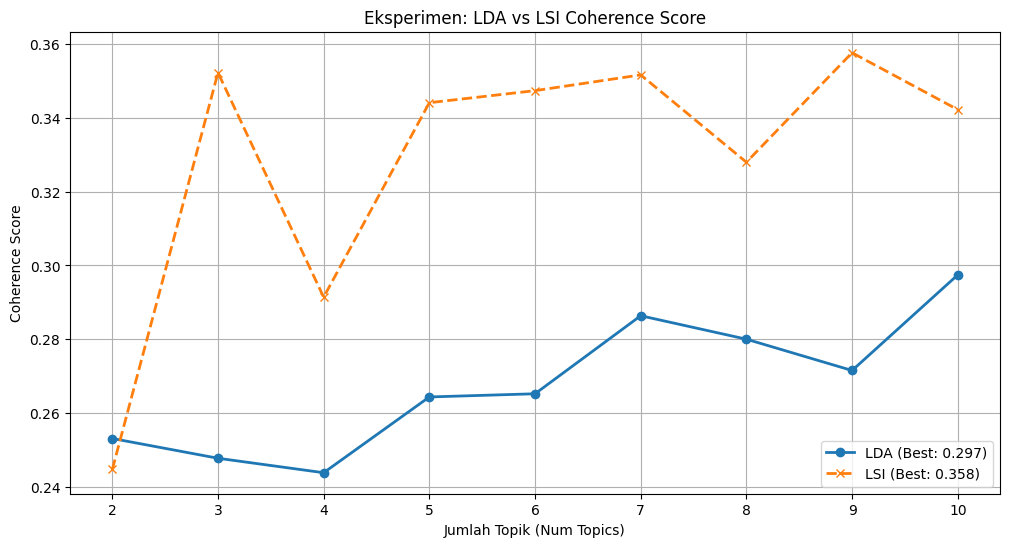

In [7]:
# Plotting
x = range(start, limit, step)

plt.figure(figsize=(12, 6))

# Garis LDA
plt.plot(x, coherence_values_lda, marker='o', label=f'LDA (Best: {best_score_lda:.3f})', linewidth=2)
# Garis LSI
plt.plot(x, coherence_values_lsi, marker='x', label=f'LSI (Best: {best_score_lsi:.3f})', linestyle='--', linewidth=2)

plt.title('Eksperimen: LDA vs LSI Coherence Score')
plt.xlabel("Jumlah Topik (Num Topics)")
plt.ylabel("Coherence Score")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Tentukan Pemenang
if best_score_lda > best_score_lsi:
    print(f"WINNER: LDA dengan {best_k_lda} Topik.")
    best_model = model_list_lda[coherence_values_lda.index(best_score_lda)]
else:
    print(f"WINNER: LSI dengan {best_k_lsi} Topik.")
    best_model = model_list_lsi[coherence_values_lsi.index(best_score_lsi)]

# Tampilkan Keyword per Topik
print("\nISI TOPIK TERBAIK:")
topics = best_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

WINNER: LSI dengan 9 Topik.

ISI TOPIK TERBAIK:
(0, '0.779*"allcaps" + 0.507*"number" + 0.324*"covid" + 0.069*"repeated" + 0.049*"orang" + 0.040*"virus" + 0.036*"cegah" + 0.034*"sebar" + 0.030*"corona" + 0.029*"indonesia"')
(1, '-0.666*"number" + 0.616*"allcaps" + -0.346*"covid" + -0.147*"repeated" + -0.091*"orang" + -0.039*"iya" + -0.039*"moga" + -0.032*"rumah" + -0.029*"tinggal" + -0.026*"positif"')
(2, '-0.810*"repeated" + 0.376*"number" + -0.326*"covid" + -0.124*"iya" + -0.097*"moga" + -0.069*"allah" + -0.056*"rumah" + -0.048*"wabah" + -0.046*"elongated" + -0.044*"kena"')
(3, '0.712*"covid" + -0.497*"repeated" + -0.336*"number" + -0.117*"orang" + 0.113*"virus" + 0.101*"moga" + 0.077*"rumah" + -0.063*"allcaps" + 0.052*"iya" + 0.051*"cegah"')
(4, '-0.511*"orang" + 0.426*"virus" + 0.328*"moga" + 0.294*"corona" + 0.229*"cegah" + 0.193*"sebar" + -0.165*"covid" + -0.114*"pasien" + 0.111*"sehat" + 0.105*"wabah"')
(5, '-0.691*"moga" + -0.336*"iya" + 0.216*"cegah" + -0.186*"allah" + 0.185*"